In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jul 14 10:43:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 32%   44C    P0    34W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-3, 217)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 11.95 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.14 s
Constructing 160000 event dataset took 4.2 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 3.051 s
Constructing 9984 event dataset took 0.1234 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelB()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/45f4cbc6e8f54804ba333a929d359a76/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_B(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


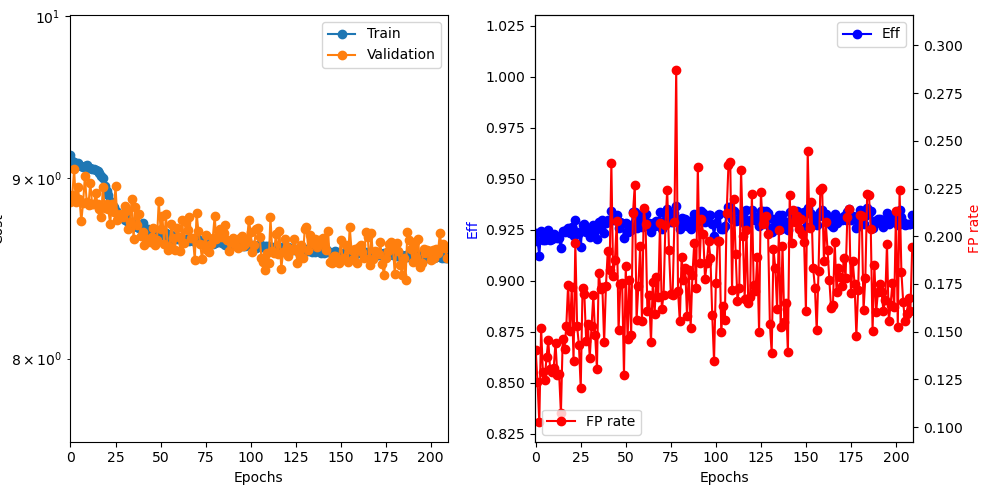

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
print('for model: ', model)   
run_name = 'ACNN B'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_B(
  (conv1): Conv1d(1, 16, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(16, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(9, 9, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(9, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 217
batch_size 128
epochs 1000
lr 0.001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 217: train=9.13413, val=8.85915, took 30.013 s
  Validation Found 50312 of 54504, added 1402 (eff 92.31%) (0.14 FP/event)


Epoch 218: train=9.09791, val=8.90017, took 29.804 s
  Validation Found 50115 of 54504, added 1232 (eff 91.95%) (0.123 FP/event)


Epoch 219: train=9.09318, val=9.04964, took 29.83 s
  Validation Found 49721 of 54504, added 1024 (eff 91.22%) (0.103 FP/event)


Epoch 220: train=9.08258, val=8.86163, took 29.794 s
  Validation Found 50372 of 54504, added 1519 (eff 92.42%) (0.152 FP/event)


Epoch 221: train=9.08528, val=8.94505, took 29.772 s
  Validation Found 50151 of 54504, added 1288 (eff 92.01%) (0.129 FP/event)


Epoch 222: train=9.07556, val=8.876, took 29.688 s
  Validation Found 50129 of 54504, added 1245 (eff 91.97%) (0.125 FP/event)


Epoch 223: train=9.0717, val=8.7491, took 30.264 s
  Validation Found 50308 of 54504, added 1364 (eff 92.30%) (0.137 FP/event)


Epoch 224: train=9.06447, val=8.85591, took 30.376 s
  Validation Found 50410 of 54504, added 1452 (eff 92.49%) (0.145 FP/event)


Epoch 225: train=9.06863, val=9.01038, took 30.397 s
  Validation Found 50127 of 54504, added 1301 (eff 91.97%) (0.13 FP/event)


Epoch 226: train=9.07449, val=8.8608, took 30.22 s
  Validation Found 50169 of 54504, added 1287 (eff 92.05%) (0.129 FP/event)


Epoch 227: train=9.06065, val=8.84507, took 29.793 s
  Validation Found 50295 of 54504, added 1308 (eff 92.28%) (0.131 FP/event)


Epoch 228: train=9.06116, val=8.97268, took 30.145 s
  Validation Found 50257 of 54504, added 1440 (eff 92.21%) (0.144 FP/event)


Epoch 229: train=9.04947, val=8.84867, took 29.832 s
  Validation Found 50183 of 54504, added 1270 (eff 92.07%) (0.127 FP/event)


Epoch 230: train=9.04983, val=8.84645, took 29.83 s
  Validation Found 50184 of 54504, added 1278 (eff 92.07%) (0.128 FP/event)


Epoch 231: train=9.04712, val=8.91073, took 30.26 s
  Validation Found 49926 of 54504, added 1071 (eff 91.60%) (0.107 FP/event)


Epoch 232: train=9.04168, val=8.85074, took 29.837 s
  Validation Found 50392 of 54504, added 1458 (eff 92.46%) (0.146 FP/event)


Epoch 233: train=9.02783, val=8.81931, took 29.828 s
  Validation Found 50352 of 54504, added 1409 (eff 92.38%) (0.141 FP/event)


Epoch 234: train=9.01305, val=8.77548, took 29.941 s
  Validation Found 50412 of 54504, added 1529 (eff 92.49%) (0.153 FP/event)


Epoch 235: train=8.99969, val=8.94504, took 29.741 s
  Validation Found 50452 of 54504, added 1744 (eff 92.57%) (0.175 FP/event)


Epoch 236: train=8.94997, val=8.82369, took 29.721 s
  Validation Found 50334 of 54504, added 1499 (eff 92.35%) (0.15 FP/event)


Epoch 237: train=8.92339, val=8.84778, took 29.88 s
  Validation Found 50483 of 54504, added 1729 (eff 92.62%) (0.173 FP/event)


Epoch 238: train=8.90028, val=8.819, took 29.837 s
  Validation Found 50257 of 54504, added 1346 (eff 92.21%) (0.135 FP/event)


Epoch 239: train=8.86569, val=8.73493, took 29.896 s
  Validation Found 50668 of 54504, added 1964 (eff 92.96%) (0.197 FP/event)


Epoch 240: train=8.84977, val=8.84935, took 29.977 s
  Validation Found 50360 of 54504, added 1526 (eff 92.40%) (0.153 FP/event)


Epoch 241: train=8.82903, val=8.80455, took 29.597 s
  Validation Found 50313 of 54504, added 1426 (eff 92.31%) (0.143 FP/event)


Epoch 242: train=8.80799, val=8.95142, took 29.937 s
  Validation Found 49946 of 54504, added 1201 (eff 91.64%) (0.12 FP/event)


Epoch 243: train=8.80463, val=8.75686, took 30.056 s
  Validation Found 50545 of 54504, added 1724 (eff 92.74%) (0.173 FP/event)


Epoch 244: train=8.78201, val=8.78755, took 29.963 s
  Validation Found 50554 of 54504, added 1695 (eff 92.75%) (0.17 FP/event)


Epoch 245: train=8.78449, val=8.78991, took 29.914 s
  Validation Found 50359 of 54504, added 1451 (eff 92.40%) (0.145 FP/event)


Epoch 246: train=8.76753, val=8.77288, took 29.705 s
  Validation Found 50423 of 54504, added 1537 (eff 92.51%) (0.154 FP/event)


Epoch 247: train=8.75566, val=8.83864, took 29.686 s
  Validation Found 50214 of 54504, added 1361 (eff 92.13%) (0.136 FP/event)


Epoch 248: train=8.77359, val=8.80994, took 29.733 s
  Validation Found 50410 of 54504, added 1526 (eff 92.49%) (0.153 FP/event)


Epoch 249: train=8.74787, val=8.70352, took 29.823 s
  Validation Found 50537 of 54504, added 1689 (eff 92.72%) (0.169 FP/event)


Epoch 250: train=8.73444, val=8.7429, took 29.753 s
  Validation Found 50369 of 54504, added 1479 (eff 92.41%) (0.148 FP/event)


Epoch 251: train=8.74319, val=8.8799, took 30.152 s
  Validation Found 50163 of 54504, added 1303 (eff 92.04%) (0.13 FP/event)


Epoch 252: train=8.7343, val=8.6475, took 29.775 s
  Validation Found 50618 of 54504, added 1807 (eff 92.87%) (0.181 FP/event)


Epoch 253: train=8.73305, val=8.83374, took 29.813 s
  Validation Found 50464 of 54504, added 1722 (eff 92.59%) (0.172 FP/event)


Epoch 254: train=8.71605, val=8.72878, took 29.768 s
  Validation Found 50672 of 54504, added 1732 (eff 92.97%) (0.173 FP/event)


Epoch 255: train=8.71261, val=8.79283, took 29.664 s
  Validation Found 50326 of 54504, added 1443 (eff 92.33%) (0.145 FP/event)


Epoch 256: train=8.71077, val=8.66649, took 29.674 s
  Validation Found 50586 of 54504, added 1737 (eff 92.81%) (0.174 FP/event)


Epoch 257: train=8.74062, val=8.68983, took 29.869 s
  Validation Found 50660 of 54504, added 1919 (eff 92.95%) (0.192 FP/event)


Epoch 258: train=8.70194, val=8.61383, took 29.673 s
  Validation Found 50633 of 54504, added 1819 (eff 92.90%) (0.182 FP/event)


Epoch 259: train=8.70009, val=8.65142, took 29.599 s
  Validation Found 50910 of 54504, added 2379 (eff 93.41%) (0.238 FP/event)


Epoch 260: train=8.70371, val=8.64919, took 29.627 s
  Validation Found 50689 of 54504, added 1788 (eff 93.00%) (0.179 FP/event)


Epoch 261: train=8.68503, val=8.63271, took 29.627 s
  Validation Found 50662 of 54504, added 1874 (eff 92.95%) (0.188 FP/event)


Epoch 262: train=8.69698, val=8.65742, took 29.699 s
  Validation Found 50806 of 54504, added 2078 (eff 93.22%) (0.208 FP/event)


Epoch 263: train=8.69279, val=8.71163, took 29.697 s
  Validation Found 50448 of 54504, added 1504 (eff 92.56%) (0.151 FP/event)


Epoch 264: train=8.68409, val=8.61283, took 29.662 s
  Validation Found 50613 of 54504, added 1749 (eff 92.86%) (0.175 FP/event)


Epoch 265: train=8.67916, val=8.64311, took 29.602 s
  Validation Found 50588 of 54504, added 1752 (eff 92.82%) (0.175 FP/event)


Epoch 266: train=8.67972, val=8.86762, took 29.605 s
  Validation Found 50195 of 54504, added 1270 (eff 92.09%) (0.127 FP/event)


Epoch 267: train=8.66861, val=8.703, took 29.695 s
  Validation Found 50585 of 54504, added 1841 (eff 92.81%) (0.184 FP/event)


Epoch 268: train=8.6686, val=8.78012, took 29.88 s
  Validation Found 50358 of 54504, added 1459 (eff 92.39%) (0.146 FP/event)


Epoch 269: train=8.67692, val=8.62154, took 29.938 s
  Validation Found 50550 of 54504, added 1768 (eff 92.75%) (0.177 FP/event)


Epoch 270: train=8.6814, val=8.79353, took 29.788 s
  Validation Found 50411 of 54504, added 1479 (eff 92.49%) (0.148 FP/event)


Epoch 271: train=8.65659, val=8.58625, took 29.708 s
  Validation Found 50878 of 54504, added 2118 (eff 93.35%) (0.212 FP/event)


Epoch 272: train=8.6499, val=8.60425, took 29.651 s
  Validation Found 50882 of 54504, added 2265 (eff 93.35%) (0.227 FP/event)


Epoch 273: train=8.67125, val=8.73088, took 29.676 s
  Validation Found 50461 of 54504, added 1559 (eff 92.58%) (0.156 FP/event)


Epoch 274: train=8.65278, val=8.65422, took 29.667 s
  Validation Found 50632 of 54504, added 1739 (eff 92.90%) (0.174 FP/event)


Epoch 275: train=8.66226, val=8.58964, took 29.673 s
  Validation Found 50802 of 54504, added 1945 (eff 93.21%) (0.195 FP/event)


Epoch 276: train=8.65106, val=8.71037, took 29.675 s
  Validation Found 50479 of 54504, added 1554 (eff 92.62%) (0.156 FP/event)


Epoch 277: train=8.65047, val=8.66015, took 29.765 s
  Validation Found 50762 of 54504, added 2145 (eff 93.13%) (0.215 FP/event)


Epoch 278: train=8.65258, val=8.58363, took 29.651 s
  Validation Found 50834 of 54504, added 2059 (eff 93.27%) (0.206 FP/event)


Epoch 279: train=8.6494, val=8.75428, took 29.667 s
  Validation Found 50515 of 54504, added 1607 (eff 92.68%) (0.161 FP/event)


Epoch 280: train=8.64507, val=8.62888, took 29.633 s
  Validation Found 50592 of 54504, added 1687 (eff 92.82%) (0.169 FP/event)


Epoch 281: train=8.64967, val=8.74405, took 29.613 s
  Validation Found 50355 of 54504, added 1442 (eff 92.39%) (0.144 FP/event)


Epoch 282: train=8.64829, val=8.7001, took 29.643 s
  Validation Found 50599 of 54504, added 1756 (eff 92.84%) (0.176 FP/event)


Epoch 283: train=8.63769, val=8.7759, took 29.57 s
  Validation Found 50507 of 54504, added 1589 (eff 92.67%) (0.159 FP/event)


Epoch 284: train=8.64819, val=8.65462, took 29.636 s
  Validation Found 50654 of 54504, added 1786 (eff 92.94%) (0.179 FP/event)


Epoch 285: train=8.63815, val=8.65259, took 29.62 s
  Validation Found 50599 of 54504, added 1677 (eff 92.84%) (0.168 FP/event)


Epoch 286: train=8.6435, val=8.52898, took 29.558 s
  Validation Found 50875 of 54504, added 2064 (eff 93.34%) (0.207 FP/event)


Epoch 287: train=8.65707, val=8.79559, took 29.625 s
  Validation Found 50420 of 54504, added 1614 (eff 92.51%) (0.162 FP/event)


Epoch 288: train=8.638, val=8.69542, took 29.727 s
  Validation Found 50636 of 54504, added 1691 (eff 92.90%) (0.169 FP/event)


Epoch 289: train=8.63351, val=8.61909, took 29.653 s
  Validation Found 50849 of 54504, added 2056 (eff 93.29%) (0.206 FP/event)


Epoch 290: train=8.62818, val=8.53794, took 29.635 s
  Validation Found 50974 of 54504, added 2239 (eff 93.52%) (0.224 FP/event)


Epoch 291: train=8.64278, val=8.61584, took 29.501 s
  Validation Found 50788 of 54504, added 1927 (eff 93.18%) (0.193 FP/event)


Epoch 292: train=8.63065, val=8.67068, took 29.63 s
  Validation Found 50629 of 54504, added 1697 (eff 92.89%) (0.17 FP/event)


Epoch 293: train=8.62715, val=8.58515, took 29.618 s
  Validation Found 50616 of 54504, added 1690 (eff 92.87%) (0.169 FP/event)


Epoch 294: train=8.63162, val=8.57593, took 29.646 s
  Validation Found 50870 of 54504, added 2071 (eff 93.33%) (0.207 FP/event)


Epoch 295: train=8.62725, val=8.6227, took 29.641 s
  Validation Found 51045 of 54504, added 2868 (eff 93.65%) (0.287 FP/event)


Epoch 296: train=8.62249, val=8.65668, took 29.727 s
  Validation Found 50660 of 54504, added 1712 (eff 92.95%) (0.171 FP/event)


Epoch 297: train=8.62794, val=8.77702, took 29.681 s
  Validation Found 50425 of 54504, added 1551 (eff 92.52%) (0.155 FP/event)


Epoch 298: train=8.63923, val=8.64979, took 29.602 s
  Validation Found 50734 of 54504, added 1889 (eff 93.08%) (0.189 FP/event)


Epoch 299: train=8.6304, val=8.69552, took 29.607 s
  Validation Found 50594 of 54504, added 1769 (eff 92.83%) (0.177 FP/event)


Epoch 300: train=8.63571, val=8.70525, took 29.595 s
  Validation Found 50696 of 54504, added 1830 (eff 93.01%) (0.183 FP/event)


Epoch 301: train=8.6266, val=8.65975, took 29.592 s
  Validation Found 50519 of 54504, added 1580 (eff 92.69%) (0.158 FP/event)


Epoch 302: train=8.63456, val=8.68372, took 29.61 s
  Validation Found 50637 of 54504, added 1819 (eff 92.91%) (0.182 FP/event)


Epoch 303: train=8.61401, val=8.7288, took 29.546 s
  Validation Found 50438 of 54504, added 1516 (eff 92.54%) (0.152 FP/event)


Epoch 304: train=8.6313, val=8.64539, took 29.481 s
  Validation Found 50651 of 54504, added 1795 (eff 92.93%) (0.18 FP/event)


Epoch 305: train=8.62745, val=8.58368, took 29.482 s
  Validation Found 50823 of 54504, added 1959 (eff 93.25%) (0.196 FP/event)


Epoch 306: train=8.61919, val=8.63321, took 29.637 s
  Validation Found 50586 of 54504, added 1724 (eff 92.81%) (0.173 FP/event)


Epoch 307: train=8.62041, val=8.65205, took 29.646 s
  Validation Found 50834 of 54504, added 2360 (eff 93.27%) (0.236 FP/event)


Epoch 308: train=8.62235, val=8.63516, took 29.566 s
  Validation Found 50714 of 54504, added 1855 (eff 93.05%) (0.186 FP/event)


Epoch 309: train=8.61504, val=8.61044, took 29.611 s
  Validation Found 50910 of 54504, added 2085 (eff 93.41%) (0.209 FP/event)


Epoch 310: train=8.61351, val=8.59832, took 29.517 s
  Validation Found 50857 of 54504, added 2007 (eff 93.31%) (0.201 FP/event)


Epoch 311: train=8.62069, val=8.65269, took 29.551 s
  Validation Found 50630 of 54504, added 1773 (eff 92.89%) (0.178 FP/event)


Epoch 312: train=8.62021, val=8.66596, took 29.616 s
  Validation Found 50725 of 54504, added 1856 (eff 93.07%) (0.186 FP/event)


Epoch 313: train=8.60954, val=8.60861, took 29.574 s
  Validation Found 50810 of 54504, added 1971 (eff 93.22%) (0.197 FP/event)


Epoch 314: train=8.60902, val=8.62048, took 29.57 s
  Validation Found 50801 of 54504, added 1883 (eff 93.21%) (0.189 FP/event)


Epoch 315: train=8.61342, val=8.64142, took 29.719 s
  Validation Found 50576 of 54504, added 1585 (eff 92.79%) (0.159 FP/event)


Epoch 316: train=8.61565, val=8.75866, took 29.682 s
  Validation Found 50254 of 54504, added 1342 (eff 92.20%) (0.134 FP/event)


Epoch 317: train=8.61621, val=8.68943, took 29.681 s
  Validation Found 50582 of 54504, added 1750 (eff 92.80%) (0.175 FP/event)


Epoch 318: train=8.6115, val=8.57658, took 29.573 s
  Validation Found 50811 of 54504, added 1974 (eff 93.22%) (0.198 FP/event)


Epoch 319: train=8.61413, val=8.61355, took 29.553 s
  Validation Found 50833 of 54504, added 1973 (eff 93.26%) (0.198 FP/event)


Epoch 320: train=8.60079, val=8.70287, took 29.663 s
  Validation Found 50440 of 54504, added 1495 (eff 92.54%) (0.15 FP/event)


Epoch 321: train=8.61017, val=8.71142, took 29.645 s
  Validation Found 50424 of 54504, added 1633 (eff 92.51%) (0.164 FP/event)


Epoch 322: train=8.62057, val=8.66268, took 29.87 s
  Validation Found 50520 of 54504, added 1561 (eff 92.69%) (0.156 FP/event)


Epoch 323: train=8.60271, val=8.54236, took 29.663 s
  Validation Found 50830 of 54504, added 2121 (eff 93.26%) (0.212 FP/event)


Epoch 324: train=8.60564, val=8.52031, took 29.618 s
  Validation Found 51009 of 54504, added 2369 (eff 93.59%) (0.237 FP/event)


Epoch 325: train=8.60831, val=8.47713, took 30.005 s
  Validation Found 51028 of 54504, added 2386 (eff 93.62%) (0.239 FP/event)


Epoch 326: train=8.60894, val=8.57218, took 29.859 s
  Validation Found 50700 of 54504, added 1715 (eff 93.02%) (0.172 FP/event)


Epoch 327: train=8.60666, val=8.51521, took 29.604 s
  Validation Found 50916 of 54504, added 2190 (eff 93.42%) (0.219 FP/event)


Epoch 328: train=8.59903, val=8.77089, took 29.569 s
  Validation Found 50652 of 54504, added 1906 (eff 92.93%) (0.191 FP/event)


Epoch 329: train=8.59977, val=8.5836, took 29.502 s
  Validation Found 50669 of 54504, added 1660 (eff 92.96%) (0.166 FP/event)


Epoch 330: train=8.58487, val=8.57009, took 29.703 s
  Validation Found 50689 of 54504, added 1728 (eff 93.00%) (0.173 FP/event)


Epoch 331: train=8.60678, val=8.67701, took 29.64 s
  Validation Found 50831 of 54504, added 2345 (eff 93.26%) (0.235 FP/event)


Epoch 332: train=8.58721, val=8.56197, took 29.645 s
  Validation Found 50837 of 54504, added 1998 (eff 93.27%) (0.2 FP/event)


Epoch 333: train=8.60317, val=8.6941, took 29.641 s
  Validation Found 50570 of 54504, added 1669 (eff 92.78%) (0.167 FP/event)


Epoch 334: train=8.6029, val=8.4803, took 29.665 s
  Validation Found 50935 of 54504, added 2029 (eff 93.45%) (0.203 FP/event)


Epoch 335: train=8.59346, val=8.57536, took 29.805 s
  Validation Found 50599 of 54504, added 1649 (eff 92.84%) (0.165 FP/event)


Epoch 336: train=8.58809, val=8.64655, took 29.793 s
  Validation Found 50663 of 54504, added 1677 (eff 92.95%) (0.168 FP/event)


Epoch 337: train=8.58815, val=8.60444, took 29.662 s
  Validation Found 50932 of 54504, added 2220 (eff 93.45%) (0.222 FP/event)


Epoch 338: train=8.60136, val=8.55286, took 29.655 s
  Validation Found 50695 of 54504, added 1742 (eff 93.01%) (0.174 FP/event)


Epoch 339: train=8.58538, val=8.59346, took 29.676 s
  Validation Found 50671 of 54504, added 1709 (eff 92.97%) (0.171 FP/event)


Epoch 340: train=8.5974, val=8.58527, took 29.748 s
  Validation Found 50755 of 54504, added 1887 (eff 93.12%) (0.189 FP/event)


Epoch 341: train=8.58954, val=8.6477, took 29.796 s
  Validation Found 50499 of 54504, added 1498 (eff 92.65%) (0.15 FP/event)


Epoch 342: train=8.59481, val=8.5911, took 29.512 s
  Validation Found 50907 of 54504, added 2231 (eff 93.40%) (0.223 FP/event)


Epoch 343: train=8.58709, val=8.51573, took 29.496 s
  Validation Found 50919 of 54504, added 2062 (eff 93.42%) (0.207 FP/event)


Epoch 344: train=8.59497, val=8.5689, took 29.529 s
  Validation Found 50873 of 54504, added 2066 (eff 93.34%) (0.207 FP/event)


Epoch 345: train=8.58565, val=8.61361, took 29.53 s
  Validation Found 50901 of 54504, added 2101 (eff 93.39%) (0.21 FP/event)


Epoch 346: train=8.59097, val=8.54042, took 29.625 s
  Validation Found 50870 of 54504, added 2011 (eff 93.33%) (0.201 FP/event)


Epoch 347: train=8.58718, val=8.70269, took 29.726 s
  Validation Found 50470 of 54504, added 1536 (eff 92.60%) (0.154 FP/event)


Epoch 348: train=8.59076, val=8.71733, took 29.659 s
  Validation Found 50341 of 54504, added 1386 (eff 92.36%) (0.139 FP/event)


Epoch 349: train=8.57988, val=8.58877, took 29.918 s
  Validation Found 50707 of 54504, added 1928 (eff 93.03%) (0.193 FP/event)


Epoch 350: train=8.59206, val=8.66927, took 29.718 s
  Validation Found 50509 of 54504, added 1831 (eff 92.67%) (0.183 FP/event)


Epoch 351: train=8.57781, val=8.62752, took 29.78 s
  Validation Found 50617 of 54504, added 1616 (eff 92.87%) (0.162 FP/event)


Epoch 352: train=8.58705, val=8.62729, took 29.602 s
  Validation Found 50819 of 54504, added 2028 (eff 93.24%) (0.203 FP/event)


Epoch 353: train=8.57714, val=8.64622, took 29.807 s
  Validation Found 50426 of 54504, added 1520 (eff 92.52%) (0.152 FP/event)


Epoch 354: train=8.59377, val=8.604, took 29.783 s
  Validation Found 50805 of 54504, added 1947 (eff 93.21%) (0.195 FP/event)


Epoch 355: train=8.63061, val=8.6447, took 29.821 s
  Validation Found 50530 of 54504, added 1548 (eff 92.71%) (0.155 FP/event)


Epoch 356: train=8.57174, val=8.64025, took 29.793 s
  Validation Found 50628 of 54504, added 1647 (eff 92.89%) (0.165 FP/event)


Epoch 357: train=8.58213, val=8.65555, took 29.829 s
  Validation Found 50395 of 54504, added 1389 (eff 92.46%) (0.139 FP/event)


Epoch 358: train=8.57137, val=8.61833, took 29.837 s
  Validation Found 50890 of 54504, added 2211 (eff 93.37%) (0.221 FP/event)


Epoch 359: train=8.59338, val=8.58669, took 29.56 s
  Validation Found 50759 of 54504, added 1960 (eff 93.13%) (0.196 FP/event)


Epoch 360: train=8.57403, val=8.69458, took 29.475 s
  Validation Found 50778 of 54504, added 2134 (eff 93.16%) (0.214 FP/event)


Epoch 361: train=8.57725, val=8.51945, took 29.634 s
  Validation Found 50883 of 54504, added 2073 (eff 93.36%) (0.208 FP/event)


Epoch 362: train=8.5702, val=8.51702, took 29.604 s
  Validation Found 50905 of 54504, added 2101 (eff 93.40%) (0.21 FP/event)


Epoch 363: train=8.57156, val=8.55297, took 29.636 s
  Validation Found 50810 of 54504, added 2035 (eff 93.22%) (0.204 FP/event)


Epoch 364: train=8.57978, val=8.55275, took 29.619 s
  Validation Found 50865 of 54504, added 2085 (eff 93.32%) (0.209 FP/event)


Epoch 365: train=8.57784, val=8.52986, took 29.589 s
  Validation Found 50759 of 54504, added 2010 (eff 93.13%) (0.201 FP/event)


Epoch 366: train=8.57192, val=8.51366, took 29.581 s
  Validation Found 50873 of 54504, added 1967 (eff 93.34%) (0.197 FP/event)


Epoch 367: train=8.56739, val=8.6406, took 29.624 s
  Validation Found 50498 of 54504, added 1606 (eff 92.65%) (0.161 FP/event)


Epoch 368: train=8.5697, val=8.54094, took 29.678 s
  Validation Found 50982 of 54504, added 2441 (eff 93.54%) (0.244 FP/event)


Epoch 369: train=8.56272, val=8.53488, took 29.598 s
  Validation Found 50863 of 54504, added 2041 (eff 93.32%) (0.204 FP/event)


Epoch 370: train=8.5711, val=8.61476, took 29.973 s
  Validation Found 50834 of 54504, added 2176 (eff 93.27%) (0.218 FP/event)


Epoch 371: train=8.56424, val=8.52274, took 30.053 s
  Validation Found 50775 of 54504, added 1833 (eff 93.16%) (0.184 FP/event)


Epoch 372: train=8.56755, val=8.7188, took 29.669 s
  Validation Found 50590 of 54504, added 1726 (eff 92.82%) (0.173 FP/event)


Epoch 373: train=8.57833, val=8.5866, took 29.851 s
  Validation Found 50541 of 54504, added 1504 (eff 92.73%) (0.151 FP/event)


Epoch 374: train=8.57589, val=8.53902, took 29.731 s
  Validation Found 50771 of 54504, added 1815 (eff 93.15%) (0.182 FP/event)


Epoch 375: train=8.56686, val=8.59267, took 29.634 s
  Validation Found 50891 of 54504, added 2239 (eff 93.37%) (0.224 FP/event)


Epoch 376: train=8.57118, val=8.514, took 29.643 s
  Validation Found 50937 of 54504, added 2251 (eff 93.46%) (0.225 FP/event)


Epoch 377: train=8.57254, val=8.60408, took 29.679 s
  Validation Found 50784 of 54504, added 1867 (eff 93.17%) (0.187 FP/event)


Epoch 378: train=8.56768, val=8.6156, took 29.63 s
  Validation Found 50843 of 54504, added 2073 (eff 93.28%) (0.208 FP/event)


Epoch 379: train=8.56992, val=8.57671, took 29.823 s
  Validation Found 50759 of 54504, added 1927 (eff 93.13%) (0.193 FP/event)


Epoch 380: train=8.57668, val=8.54173, took 29.673 s
  Validation Found 50692 of 54504, added 1768 (eff 93.01%) (0.177 FP/event)


Epoch 381: train=8.57344, val=8.68584, took 29.64 s
  Validation Found 50550 of 54504, added 1619 (eff 92.75%) (0.162 FP/event)


Epoch 382: train=8.57302, val=8.65969, took 29.706 s
  Validation Found 50488 of 54504, added 1635 (eff 92.63%) (0.164 FP/event)


Epoch 383: train=8.55651, val=8.50107, took 29.773 s
  Validation Found 50836 of 54504, added 1968 (eff 93.27%) (0.197 FP/event)


Epoch 384: train=8.55684, val=8.67998, took 29.62 s
  Validation Found 50585 of 54504, added 1707 (eff 92.81%) (0.171 FP/event)


Epoch 385: train=8.54844, val=8.53877, took 29.502 s
  Validation Found 50710 of 54504, added 1833 (eff 93.04%) (0.184 FP/event)


Epoch 386: train=8.56013, val=8.58045, took 29.601 s
  Validation Found 50724 of 54504, added 1784 (eff 93.06%) (0.179 FP/event)


Epoch 387: train=8.55867, val=8.57839, took 29.811 s
  Validation Found 50671 of 54504, added 1738 (eff 92.97%) (0.174 FP/event)


Epoch 388: train=8.56089, val=8.56653, took 29.861 s
  Validation Found 50783 of 54504, added 1884 (eff 93.17%) (0.189 FP/event)


Epoch 389: train=8.57289, val=8.63193, took 29.742 s
  Validation Found 50660 of 54504, added 1780 (eff 92.95%) (0.178 FP/event)


Epoch 390: train=8.56287, val=8.51058, took 29.553 s
  Validation Found 50891 of 54504, added 2099 (eff 93.37%) (0.21 FP/event)


Epoch 391: train=8.56887, val=8.451, took 29.685 s
  Validation Found 50979 of 54504, added 2139 (eff 93.53%) (0.214 FP/event)


Epoch 392: train=8.55809, val=8.54243, took 29.704 s
  Validation Found 50662 of 54504, added 1702 (eff 92.95%) (0.17 FP/event)


Epoch 393: train=8.56503, val=8.58393, took 29.724 s
  Validation Found 50781 of 54504, added 1865 (eff 93.17%) (0.187 FP/event)


Epoch 394: train=8.55652, val=8.61948, took 29.796 s
  Validation Found 50730 of 54504, added 1749 (eff 93.08%) (0.175 FP/event)


Epoch 395: train=8.56698, val=8.63372, took 30.278 s
  Validation Found 50447 of 54504, added 1477 (eff 92.56%) (0.148 FP/event)


Epoch 396: train=8.56124, val=8.60431, took 30.001 s
  Validation Found 50664 of 54504, added 1718 (eff 92.95%) (0.172 FP/event)


Epoch 397: train=8.56645, val=8.45353, took 29.628 s
  Validation Found 50944 of 54504, added 2107 (eff 93.47%) (0.211 FP/event)


Epoch 398: train=8.55109, val=8.62463, took 29.615 s
  Validation Found 50783 of 54504, added 2102 (eff 93.17%) (0.211 FP/event)


Epoch 399: train=8.55574, val=8.58326, took 29.913 s
  Validation Found 50569 of 54504, added 1611 (eff 92.78%) (0.161 FP/event)


Epoch 400: train=8.56164, val=8.50479, took 29.606 s
  Validation Found 50769 of 54504, added 1781 (eff 93.15%) (0.178 FP/event)


Epoch 401: train=8.5605, val=8.451, took 29.751 s
  Validation Found 51003 of 54504, added 2220 (eff 93.58%) (0.222 FP/event)


Epoch 402: train=8.54965, val=8.54478, took 29.663 s
  Validation Found 50858 of 54504, added 2212 (eff 93.31%) (0.222 FP/event)


Epoch 403: train=8.56064, val=8.42082, took 29.598 s
  Validation Found 50907 of 54504, added 2036 (eff 93.40%) (0.204 FP/event)


Epoch 404: train=8.54986, val=8.6874, took 29.784 s
  Validation Found 50464 of 54504, added 1503 (eff 92.59%) (0.151 FP/event)


Epoch 405: train=8.55164, val=8.64426, took 29.687 s
  Validation Found 50646 of 54504, added 1849 (eff 92.92%) (0.185 FP/event)


Epoch 406: train=8.56322, val=8.59361, took 29.688 s
  Validation Found 50599 of 54504, added 1601 (eff 92.84%) (0.16 FP/event)


Epoch 407: train=8.55157, val=8.52177, took 29.785 s
  Validation Found 50704 of 54504, added 1707 (eff 93.03%) (0.171 FP/event)


Epoch 408: train=8.54743, val=8.63116, took 29.713 s
  Validation Found 50696 of 54504, added 1748 (eff 93.01%) (0.175 FP/event)


Epoch 409: train=8.55064, val=8.54909, took 29.747 s
  Validation Found 50640 of 54504, added 1707 (eff 92.91%) (0.171 FP/event)


Epoch 410: train=8.56173, val=8.65037, took 29.683 s
  Validation Found 50496 of 54504, added 1606 (eff 92.65%) (0.161 FP/event)


Epoch 411: train=8.5577, val=8.49018, took 29.702 s
  Validation Found 50683 of 54504, added 1663 (eff 92.99%) (0.167 FP/event)


Epoch 412: train=8.55273, val=8.51213, took 29.68 s
  Validation Found 50858 of 54504, added 1958 (eff 93.31%) (0.196 FP/event)


Epoch 413: train=8.53917, val=8.59513, took 29.549 s
  Validation Found 50557 of 54504, added 1551 (eff 92.76%) (0.155 FP/event)


Epoch 414: train=8.54954, val=8.57296, took 29.699 s
  Validation Found 50654 of 54504, added 1638 (eff 92.94%) (0.164 FP/event)


Epoch 415: train=8.54724, val=8.58644, took 29.653 s
  Validation Found 50715 of 54504, added 1753 (eff 93.05%) (0.176 FP/event)


Epoch 416: train=8.54997, val=8.57995, took 29.651 s
  Validation Found 50620 of 54504, added 1627 (eff 92.87%) (0.163 FP/event)


Epoch 417: train=8.54441, val=8.53274, took 29.655 s
  Validation Found 50890 of 54504, added 2130 (eff 93.37%) (0.213 FP/event)


Epoch 418: train=8.55339, val=8.5849, took 29.664 s
  Validation Found 50533 of 54504, added 1524 (eff 92.71%) (0.153 FP/event)


Epoch 419: train=8.53995, val=8.54491, took 29.662 s
  Validation Found 50947 of 54504, added 2240 (eff 93.47%) (0.224 FP/event)


Epoch 420: train=8.54728, val=8.59277, took 29.805 s
  Validation Found 50764 of 54504, added 1811 (eff 93.14%) (0.181 FP/event)


Epoch 421: train=8.55085, val=8.56968, took 30.051 s
  Validation Found 50626 of 54504, added 1653 (eff 92.88%) (0.166 FP/event)


Epoch 422: train=8.54549, val=8.68288, took 29.946 s
  Validation Found 50543 of 54504, added 1551 (eff 92.73%) (0.155 FP/event)


Epoch 423: train=8.54445, val=8.60649, took 29.88 s
  Validation Found 50572 of 54504, added 1590 (eff 92.79%) (0.159 FP/event)


Epoch 424: train=8.55749, val=8.61872, took 29.864 s
  Validation Found 50554 of 54504, added 1672 (eff 92.75%) (0.167 FP/event)


Epoch 425: train=8.54493, val=8.59649, took 29.579 s
  Validation Found 50567 of 54504, added 1604 (eff 92.78%) (0.161 FP/event)


Epoch 426: train=8.5403, val=8.54059, took 29.609 s
  Validation Found 50799 of 54504, added 1942 (eff 93.20%) (0.194 FP/event)


In [ ]:
##quit()